## 数据导入

In [44]:
import pandas as pd
all_train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
all_test_data = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

## 数据预处理

1.去除无效特征

In [50]:
print(all_train_data.shape)
print(all_train_data.iloc[0:4,:])

(1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD      

查看数据后可知，第一列的ID是无效数据，仅用于数据标注，我们可以将其去除

In [46]:
train_fea , train_y ,test_fea=all_train_data.iloc[:, 1:-1],all_test_data.iloc[:,-1],all_test_data.iloc[:, 1:]
print(train_fea.shape)
print(test_fea.shape)

(1460, 79)
(1459, 79)


2.数据标准化

先将含数字的数据归一化

In [47]:
all_fea=pd.concat((train_fea,test_fea))
num_fea=all_fea.dtypes[all_fea.dtypes!='object'].index
all_fea[num_fea] = all_fea[num_fea].apply(lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_fea[num_fea] = all_fea[num_fea].fillna(0)
print(all_fea.shape)

(2919, 79)


再将离散值化为独热码

In [49]:
all_fea = pd.get_dummies(all_fea, dummy_na=True)
print(all_fea.shape)
print(train_fea.shape)

(2919, 331)
(1460, 79)


In [ ]:
'''
num_fea=test_fea.dtypes[test_fea.dtypes!='object'].index
test_fea[num_fea] = test_fea[num_fea].apply(lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
test_fea[num_fea] = test_fea[num_fea].fillna(0)
print(test_fea.shape)
test_fea = pd.get_dummies(test_fea, dummy_na=True)
print(test_fea.shape)
'''

这里注意，如果分别处理测试集和训练集，会在独热码后产生不同的特征数，测试集为(1459,313)。这是由测试集的数据导致的。因此，要将测试集和训练集合到一起处理。

3.数据转换

将处理好的数据转为张量

In [53]:
import torch
n_train = all_train_data.shape[0]
train_features = torch.tensor(all_fea[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_fea[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(all_train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

现在，我们就将训练集中的数据化为可以利用机器学习处理的了。接下来，就可以开始训练模型

## 神经网络训练

1.首先，我们要确定评价函数

这里的损失函数比较特殊。很容易想到，1万元的房价误差对于100万元和10万元的不同房价影响不同。对于前者，我们可以说这个模型训练的还不错，但对于后者，模型就较差。所以常见的平方损失就不太好，我们要测出相对误差。

相对误差较小，即 (1-y_hat/y)^2 较小，|y_hat/y| 接近1，取对数后接近0，即对数均方误差

但是，注意到，在训练过程中，我们还是用MSE

In [51]:
from torch import nn
loss = nn.MSELoss()
def log_rmse(net, features, labels):
# 为了在取对数时进⼀步稳定该值，将⼩于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
    torch.log(labels)))
    return rmse.item()

2.训练

In [67]:
in_features = train_features.shape[1]
net=nn.Sequential(nn.Linear(in_features,1))
num_epoch=100
def set_sgd(wd):
    sgd=torch.optim.SGD([{"params":net[0].weight,'weight_decay': wd},
{"params":net[0].bias}], lr=0.001)
    return sgd

from torch.utils import data
def load_array(data_arrays, batch_size, is_train=True): 
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size=4
train_iter=load_array((train_features, train_labels), batch_size)

import matplotlib.pyplot as plt
def train_test(wd,num_epoch,net,train_features, train_labels,train_iter):
    net[0].weight.data.normal_(0, 0.01)
    net[0].bias.data.fill_(0)
    loss=nn.MSELoss()
    sgd=set_sgd(wd)
    err_train=[]
    for epoch in range(num_epoch):
        for X,y in train_iter:
            l=loss(net(X),y)
            sgd.zero_grad()
            l.backward()
            sgd.step()            
        l1=log_rmse(net,train_features,train_labels)
        err_train.append(l1)
    plt.plot(range(num_epoch),err_train,'o')
    print(err_train[-1])

0.1330980509519577


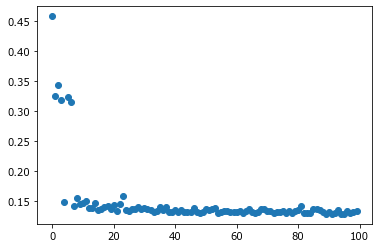

In [68]:
wd=0.0001
train_test(wd,num_epoch,net,train_features, train_labels,train_iter)